In [2]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command # using the command we can pass the command from one agent to another agent
from dotenv import load_dotenv
from IPython.display import display, Image
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated # just to mention the metadata
from langchain_experimental.utilities import PythonREPL

In [3]:
load_dotenv()

True

In [4]:
import os

groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(groq_api_key=groq_api_key, model_name="deepseek-r1-distill-llama-70b")

llm.invoke("hi").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [5]:
def add_numbers(state):
    result = state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply", update={"sum": result})

In [6]:
state={"num1":1, "num2": 2}

In [7]:
add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [8]:
@tool 
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return


@tool 
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [9]:
llm_with_tool = llm.bind_tools([transfer_to_multiplication_expert])

In [10]:
ai_message = llm_with_tool.invoke("hi how are you")

In [11]:
ai_message.tool_calls

[]

In [12]:
ai_message = llm_with_tool.invoke("what's (3 + 5) *12. Provide me the output")

In [13]:
ai_message

AIMessage(content='The result of the expression (3 + 5) * 12 is 96.\n\nStep-by-Step Explanation:\n\n1. **Parentheses First**: Solve the expression inside the parentheses.\n   - 3 + 5 = 8\n\n2. **Multiplication**: Multiply the result by 12.\n   - 8 * 12 = 96\n\nAnswer: 96', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 508, 'prompt_tokens': 131, 'total_tokens': 639, 'completion_time': 1.847272727, 'prompt_time': 0.008470604, 'queue_time': 0.06047534500000001, 'total_time': 1.855743331}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run-cbab817a-f375-4688-98e1-a4d6198165d6-0', usage_metadata={'input_tokens': 131, 'output_tokens': 508, 'total_tokens': 639})

In [14]:
ai_message.tool_calls

[]

In [15]:
ai_message = llm_with_tool.invoke("what's (3 + 5). Provide me the output")

In [16]:
ai_message.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_6ytc',
  'type': 'tool_call'}]

In [17]:
# first agent
def multiplication_expert(state: MessagesState) -> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state['messages']
    
    ai_msg= llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [18]:
# second agent
def additional_expert(state: MessagesState) -> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a addition expert, you can ask an multiplication expert for help with multiplication. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state['messages']
    
    ai_msg= llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [19]:
graph = StateGraph(MessagesState)

graph.add_node("additional_expert", additional_expert)
graph.add_node("multiplication_expert", multiplication_expert)

graph.add_edge(START, "additional_expert")

app = graph.compile()

In [20]:
display(Image(app.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [21]:
app.invoke({"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='6a46d080-201e-4f13-84b0-dc3d7c065626'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4zf5', 'function': {'arguments': '{"a": 8, "b": 12}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 351, 'prompt_tokens': 159, 'total_tokens': 510, 'completion_time': 1.381435602, 'prompt_time': 0.011922357, 'queue_time': 0.056649943, 'total_time': 1.393357959}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c02fba5c-d271-4e7a-bf3e-a95bb7a8b6f5-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {'a': 8, 'b': 12}, 'id': 'call_4zf5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 159, 'output_tokens': 351, 'total_tokens': 510}),
  ToolMessage(content='S

In [22]:
from langchain_core.messages import convert_to_messages

def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update 
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return 
        
        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}")
        print("\n")
        
    for node_name, node_update in update.items():
        print(f"Update from node {node_name}")
        print("\n")
        
        for m in convert_to_messages(node_update['messages']):
            m.pretty_print()
        print("\n")
        

In [23]:
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]}
):
    print("*****chunk...*****")
    
    pretty_print_messages(chunk)

*****chunk...*****
Update from node additional_expert


================================== Ai Message ==================================
Tool Calls:
  transfer_to_multiplication_expert (call_b373)
 Call ID: call_b373
  Args:
    addition_result: 8
    multiplier: 12
================================= Tool Message =================================

Successfully transferred


*****chunk...*****
Update from node multiplication_expert


================================== Ai Message ==================================

The result of (3 + 5) * 12 is 96.




## Second example

In [24]:
@tool 
def transfer_to_travel_advisor():
    """Ask travel advisor for help"""
    return 

@tool 
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [25]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc.) "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state['messages']
    
    ai_msg = llm.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id
        }
        
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [26]:
def hotel_advisor(state: MessagesState) ->Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given desrination."
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state['messages']
    
    ai_msg = llm.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [27]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

graph_builder.add_edge(START, "travel_advisor")

app = graph_builder.compile()

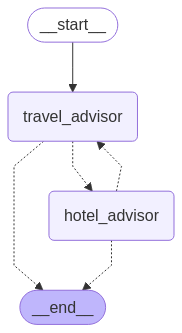

In [28]:
display(Image(app.get_graph().draw_mermaid_png()))

In [30]:
app.invoke({"messages": [("user", "I am planning a trip to the california in the SA from Mumbai. Can you guide me on travel options and suggest the best hotel with breakfast?")]})

{'messages': [HumanMessage(content='I am planning a trip to the california in the SA from Mumbai. Can you guide me on travel options and suggest the best hotel with breakfast?', additional_kwargs={}, response_metadata={}, id='c5f3028c-c99b-4649-9c9f-9d3508a40c27'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vy1h', 'function': {'arguments': '{}', 'name': 'transfer_to_hotel_advisor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 250, 'prompt_tokens': 180, 'total_tokens': 430, 'completion_time': 1.233639921, 'prompt_time': 0.011173624, 'queue_time': 0.053867674, 'total_time': 1.244813545}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d1876e59-d741-460a-876f-20c7f88d04a8-0', tool_calls=[{'name': 'transfer_to_hotel_advisor', 'args': {}, 'id': 'call_vy1h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 180, 'output_tokens': 2

In [32]:
for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the california in the SA from Mumbai. Can you guide me on travel options and suggest the best hotel with breakfast?")]}
):
    print("****chunk*******")
    pretty_print_messages(chunk)

****chunk*******
Update from node travel_advisor


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_weez)
 Call ID: call_weez
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk*******
Update from node hotel_advisor


================================== Ai Message ==================================

Great choice! California is a beautiful destination with a lot to offer. I’ll help you with travel options and hotel recommendations. Please let me know if you need further assistance!


